In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('CSS_adage', 'r') as f:
    css_style = f.read()
HTML(f'<style>{css_style}</style>')

<h1>Background</h1>

<div class = 'all'>
    <p>The data used in this project is from the <span class = 'small-caps'><b>A</b>ssessment of <b>D</b>irect oral <b>A</b>nticoagulants in <b>GE</b>riatrics </span> (<span class = 'small-caps'>Adage</span>) study. It is a European prospective, multicenter, non-interventional phase IV academic clinical trial 
    </p>
    <br>
    <b>Objectives of the <span class = 'small-caps'>Adage</span> study:</b>
        <ul>
            <li>The main objective of this study was to assess the <b>inter-individual variability of response</b> of rivaroxaban, apixaban and dabigatran in patients over <b>80 years old</b> with atrial fibrillation (AF).</li>
            <li>The secondary objective was to collect haemorrhagic and thrombotic events and deaths at six months follow-up.</li>
        </ul> 
    <br><b>Rationale of the <span class = 'small-caps'>Adage</span> study</b>
    <p>Patients over the age of 80 constitute a particularly fragile population. With a prevalence of atrial fibrillation exceeding 10%, octogenarians are increasingly benefiting from direct oral anticoagulants (DOACs). While these drugs have been extensively studied in healthy volunteers, patients included in clinical trials and those in registries [1]-[12], there is little specific data published on patients aged 80 and over with atrial fibrillation.</p>
    <p>
For further information about <span style = 'font-variant : small-caps'>Adage</span> please refer to <a href = 'https://pubmed.ncbi.nlm.nih.gov/36395818/'>this article</a> published in <i>Thrombosis and Haemostasis</i> in April 2023.
    </p>
</div>
<br>
<div class="obj">
    <p><b>Objectives of this project:</b></p>
    <ul>
        <li>To showcase data cleaning techniques and NaN handling strategies using the <span class="small-caps">Adage</span> clinical trial dataset of elderly patients with atrial fibrillation.</li>
        <li>To perform exploratory data analysis (EDA) and gain insights into the dataset, focusing on demographic, clinical, laboratory, and medication data.</li>
        <li>To preprocess and transform the dataset to prepare it for analysis, including handling missing values, addressing outliers, and encoding categorical variables.</li>
        <li>To build a machine learning model to predict the likelihood of bleeding (column "f6_12m_bleed") based on available features, despite the data limitations.</li>
        <li>To evaluate the performance of this model using appropriate evaluation metrics and discuss the challenges and limitations of modeling with a small dataset.</li>
        <li>To demonstrate proficiency in data cleaning techniques, feature engineering, and model development using Python and relevant libraries such as Pandas, NumPy, and scikit-learn.</li>
    </ul>
    <p>Overall, the project aims to showcase data cleaning skills, provide insights into the characteristics of elderly patients with atrial fibrillation, and demonstrate the process of building a machine learning model, despite the dataset's limitations.</p>
</div>

<br><div class = 'all'>
   <p><i>Please note that the results presented here may differ slightly from what has been published in scientific papers or presented at conferences. The data presented here concerns the entire cohort of patients included in the study at the termination date, while published data may concern subgroups of patients.</i></p>

</div>

<h1>Abbreviations</h1> 

<ul>
    <li>ACEI: Angiotensin-converting-enzyme inhibitors</li>
    <li><span class = 'small-caps'>Adage</span>: Assessment of Direct oral Anticogulants in GEriatrics</li>
    <li>AF: Atrial Fibrillation</li>
    <li>ARBs: Angiotensine receptors blockers</li>
    <li>BMI: Body-mass index</li>
    <li>CRP: C-reactive protein</li>
    <li>DOAC: Direct Oral Anticoagulant</li>
    <li>GFR: Glomerular filtration rate</li>
    <li>NSAID: Non-steroidal anti-inflammatory drug</li>
    <li>SNRA: Serotonin–norepinephrine releasing agent</li>
    <li>SSRI: Selective serotonin reuptake inhibitors</li>
</ul>

<h1>Functions definition</h1>

In [4]:
def pval_txt(pval):
    """
    Formats a p-value according to its value.

    If the p-value is less than 0.0001, the function returns the string 'p < 10^-4'.
    Otherwise, it returns the p-value rounded to 4 decimal places as a string, prefixed with 'p = '.

    Args:
        pval (float): The p-value to format.

    Returns:
        str: The formatted p-value.
    """
    if pval < 0.0001:
        return f'$\mathit{{p}}$ < 10\u207b\u2074'
    else:
        return '$\mathit{{p}}$ = ' + f'{pval:.4f}'

<h1>Database import</h1>

In [5]:
patients_raw = pd.read_csv('bdd_adage_viz_patients.csv', sep = ';')

from adage_viz_dicts import col_rename_patients, col_to_delete_patients

patients = patients_raw.drop(col_to_delete_patients, inplace = False, axis = 1)

patients.rename(col_rename_patients, axis = 1, inplace = True)

#Importing a dict that stores information about every columns:
with open('big_dict.txt', 'r', encoding='utf-8') as f:
    patients_col_definition = f.readlines()
patients_col_definition = [line.strip() for line in patients_col_definition]

patients_features_dict = dict(zip(patients.columns.tolist(), patients_col_definition))

patients.head()

,id,dob,age,doac,TH_article,dosing,nb_samples,cmax,cmin,max_ddim,min_ddim,fib,center_incl,incl_date,sex,weight,height,bp,heartf,liverf,alcohol,coronary,stroke,cancer,haemopathy,dementia,cirsg_tot,cirsg_comp,fa_type,high_bp,diabetes,dyslipidaemia,smoke,obesity,chadsvasc_score,hasbled_score,hemorrhages_score,nb_medications,medication_list,amiodarone,verapamil,quinidine,clarithromycin,aspirin,clopidogrel,other_antiplt,nsaid,bblocker,acei,arbs,statin,creat,clcr_cockcroft,clcr_mdrd,clcr_ckdepi,crp,albumin,hb,platelets,leucocytes,asat,alat,ggt,alp,bili,doac_start_date,completed_f6m,f6m_hospit,f6m_transfusion,f6m_bleed,f6m_bleed_type,f6m_bleed_date,f6m_te,f6m_te_type,f6m_te_date,f6m_death,f6m_death_date,f6m_still_doac,completed_f12m,f12m_hospit,f12m_transfusion,f12m_bleed,f12m_bleed_type,f12m_bleed_date,f12m_te,f12m_te_type,f12m_te_date,f12m_death,f12m_death_date,f12m_still_doac,bmi,is_crp_above_5,kidneyf_class,kidneyf_50,pgp_substrate_nb,pgp_inhib_nb,pgp_all_nb,pgp_1_all,pgp_1_substrate,pgp_1_inhib,cyp_substrate_nb,cyp_inhib_nb,cyp_induct_nb,cyp_all_nb,cyp_1_all,cyp_1_substrate,cyp_1_inhib,ssri,snra,ssri_snra,anticoagulant,amlodipine,alprazolam,atorvastatin,bisoprolol,citalopram,diazepam,diltiazem,digoxin,irbesartan,lansoprazole,losartan,mirtazapine,oxycodone,tamsulosin,simvastatin,hypnotic,cancer_haemopathy,plt_norm,hyperleuco,azole,antiarr,any_anti_plt,doac_duration,f6m_lost,f12m_lost,f6_12m_bleed,f6_12m_te,f6_12m_major_bleed,f6m_major_bleed,f12m_major_bleed,f6m_bleed_id,f6m_te_id,te_time,bleed_time,death_time,completed_genetics,abcb1_21,abcb1_26,abcb1_12,cyp_2j2,cyp_3a5,performed_any_tga,performed_fibrinography,performed_td,performed_ds,performed_ts,performed_tm,non_valid_regimen,expected_regimen,lower_regimen,higher_regimen,cmax_v,cmax_ltfib,cmax_vi,cmax_vst,cmax_cs,cmax_d,cmax_tsp,cmax_lt_td,cmax_ph_td,cmax_ttp_td,cmax_etp_td,cmax_ast,cmax_vt,cmax_lt_ds,cmax_ph_ds,cmax_ttp_ds,cmax_etp_ds,cmax_vi_ds,cmax_st_ds,cmax_lt_ds_norm,cmax_ph_ds_norm,cmax_ttp_ds_norm,cmax_etp_ds_norm,cmax_vi_ds_norm,cmax_st_ds_norm,cmax_lt_tm,cmax_ph_tm,cmax_ttp_tm,cmax_etp_tm,cmax_vi_tm,cmax_st_tm,cmax_lt_ts,cmax_ph_ts,cmax_ttp_ts,cmax_etp_ts,cmax_vi_ts,cmax_st_ts,cmax_lt_ts_norm,cmax_ph_ts_norm,cmax_ttp_ts_norm,cmax_etp_ts_norm,cmax_vs_ts_norm,cmax_st_ts_norm,cmax_lt_inhib,cmax_ph_inhib,cmax_ttp_inhib,cmax_etp_inhib,cmax_vi_inhib,cmax_st_inhib,cmin_v,cmin_ltfib,cmin_vi,cmin_vst,cmin_cs,cmin_d,cmin_tsp,cmin_lt_td,cmin_ph_td,cmin_ttp_td,cmin_etp_td,cmin_ast,cmin_vt,cmin_lt_ds,cmin_ph_ds,cmin_ttp_ds,cmin_etp_ds,cmin_vi_ds,cmin_st_ds,cmin_lt_ds_norm,cmin_ph_ds_norm,cmin_ttp_ds_norm,cmin_etp_ds_norm,cmin_vi_ds_norm,cmin_st_ds_norm,cmin_lt_tm,cmin_ph_tm,cmin_ttp_tm,cmin_etp_tm,cmin_vi_tm,cmin_st_tm,cmin_lt_ts,cmin_ph_ts,cmin_ttp_ts,cmin_etp_ts,cmin_vi_ts,cmin_st_ts,cmin_lt_ts_norm,cmin_ph_ts_norm,cmin_ttp_ts_norm,cmin_etp_ts_norm,cmin_vi_ts_norm,cmin_st_ts_norm,cmin_lt_inhib,cmin_ph_inhib,cmin_ttp_inhib,cmin_etp_inhib,cmin_vi_inhib,cmin_st_inhib
0,H001,19/10/1925,88.72,R,1,15.0,3,NaN,55.18,NaN,0.30,2.5,HEGP,10/07/14,1,80.0,162.0,210/140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,4.0,2.0,3.0,2.0,Bisoprolol ; Périndopril,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,68.0,64.0,83.0,76.0,1.0,NaN,14.4,191.0,7.4,1.0,1.0,1.0,1.0,1.0,01/04/2014,1,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.0,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,30.5,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,TT,TT,CT,GT,GA,1,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.4,1.3,68.4,49.4,1712.0,29172.0,36.9,0.3,262.3,2.1,1996.7,NaN,NaN,1.85,329.0,4.04,1682.0,199.5,15.34,1.96,63.02,2.06,82.76,24.40,1.14,8.59,87.84,10.7

<h1>Data summary</h1>

In [6]:
display(HTML(f"""
<div class = 'all'>
    <h2>Data Summary</h2>
    <h3>Overview</h3>
    <p>This dataset contains {patients.shape[0]} rows and {patients.shape[1]} columns. As the number of columns is very high,
    I've decided to limit the features to those who seemed the most relevant
    </p>
</div>
"""))

kept_cols = [
    "id", "age", "doac", "dosing", "cmax", "cmin", "fib", "sex", "weight", "bmi", "heartf", 
    "coronary", "stroke", "dementia", "cirsg_tot", "fa_type", "high_bp", "diabetes", 
    "dyslipidaemia", "smoke", "obesity", "chadsvasc_score", "hasbled_score", 
    "hemorrhages_score", "nb_medications", "amiodarone", "bblocker", "acei", "arbs", 
    "statin", "creat", "clcr_cockcroft", "albumin", "hb", "platelets", "f6m_hospit", 
    "f6m_transfusion", "f6m_death", "kidneyf_class", "kidneyf_50", "pgp_1_all", 
    "cyp_1_all", "cancer_haemopathy", "plt_norm", "hyperleuco", "any_anti_plt", 
    "f6_12m_bleed", "f6_12m_te", "non_valid_regimen", "lower_regimen", "higher_regimen", 
    "cmax_lt_ts", "cmax_ph_ts", "cmax_etp_ts", "cmax_lt_ts_norm", "cmax_ph_ts_norm", 
    "cmax_etp_ts_norm", "cmin_lt_ts", "cmin_ph_ts", "cmin_etp_ts", "cmin_lt_ts_norm", 
    "cmin_ph_ts_norm", "cmin_etp_ts_norm", 'cmax_lt_td', 'cmax_ph_td', 'cmax_etp_td',
    "cmax_v",'cmin_lt_td', 'cmin_ph_td', 'cmin_etp_td', "cmin_v" 
]
df = patients[kept_cols].copy()


display(HTML(f"""
<div class = 'all'>
    <p>This light dataset now have {df.shape[0]} rows and {df.shape[1]} columns. Using <code>df.info()</code> we can see that the majority
    of features are floats and that <code>NaNs</code> treatement will be necessary. 
    </p>
    <p>
    Rationale for this light dataset is as follow: most medical history, labs and medication related features were kept, as they are 
    easy to gather and usually available in daily practice.
    Data on doacs were also kept, as the data come from a doac PK/PD clinical trial. We may naturally assume that data about doacs
    such as plasma concentrations as Cmax or Cmin, or dosing regimen could influence bleeding risk. 
    Clinical scores were kept, as they are commonly used to asses either bleeding risk (HAS-BLED, HEMORR2HAGES), thrombotic risk
    (CHA2DS2VASc) or polypathological state (CIRS-G) and therefore frailty. Basic information uppon follow-up were kept, such 
    as hospitalisation, blood transfusion, thrombotic event and death.
    Finally, the choice of limiting thrombin generation data to STG-ThromboScreen and Thrombodynamics as we know these 2 methods
    are very different and do not correlate (unlike thrombodynamics and STG-DrugScreen).
    Among features that got deleted, here are some examples:
    <ul>
        <li><b>Liver-related parameters</b>: in patients with severe hepatic disease, all DOACs are contraindicated and warfarin should
        be used. Therefore no <span class = 'small-caps'>Adage</span> patients had liver failure and hepatic markers such as 
        AST and ALT were overall within normal values.</li>
        <li><b>Specific medications</b>: many were added from the original CRF after a review of medication lists of each patients 
        (<i>i.e.</i> amlodipine, oxycodone, atorvastatin, citalopram...) but their number was not really significant compared
        to medication classes like statin, bblocker etc.)</li>
        <li><b>GFR estimated with MDRD and CKD-epi</b>: as it is well known that both formulae provide inaccurate results on elderly
        patients, all caclulations were made using Cockcroft & Gault formula.</li>
        <li><b>TGA measurements</b>: ST-Genesia DrugScreen triggers thrombin generation with high concentration of tissue factor (TF),
        and feels less suitable compared to ST-Genesia ThromboScreen (based on previous works conclusions). Regarding fibrinography, 
        only rate of clot growth was kept as it's the most commonly used parameter to assess hypercoagulability in the literature.</li>
    </ul>
    </p>
    <h3>Taget value</h3>
    <p>
    The target variable in this dataset is a binary value indicating whether a patient bled within 12 months. 
    The classes are encoded as follows: 0 represents patients who did not experience bleeding, and 1 represents 
    patients who did experience bleeding. The dataset consists of {len(df[df["f6_12m_bleed"] == 1])} instances, 
    with approximately {df["f6_12m_bleed"].value_counts(normalize = True)[0]:.1%} of instances belonging to the 
    'did not bleed' class and approximately {df["f6_12m_bleed"].value_counts(normalize = True)[1]:.1%} of instances 
    belonging to the 'bled' class.
    </p>
     
    Missing values are distributed as follow:
    <ul>
        <li>Apixaban - {df.groupby('doac')["f6_12m_bleed"].apply(lambda x: x.isna().sum()/len(x))["A"]:.1%}</li>
        <li>Rivaroxaban - {df.groupby('doac')["f6_12m_bleed"].apply(lambda x: x.isna().sum()/len(x))["R"]:.1%}</li>
        <li>Dabigatran - {df.groupby('doac')["f6_12m_bleed"].apply(lambda x: x.isna().sum()/len(x))["D"]:.1%}.</li>
    </ul>
    Due to the declining number of patients treated by dabigatran, the focus on this subgroup of patient was made on gathering PK/PD
    data. As clinical follow-up was a highly time-consuming activity, it was decided to limit the follow-up to apixaban and rivaroxaban
    patients. Dabigatran patients wont be included in the model so it will be focused on rivaroxaban and apixaban
    (of note, rivaroxaban and apixaban are closer one to the other than they are to dabigatran as they both target FXa whereas
    dabigatran targets FIIa). Very few patients however were lost to follow-up among apixaban patients ({patients.groupby('doac')['f6m_lost'].value_counts(normalize = True)['A'][1]:.1%})
    and rivaroxaban patients ({patients.groupby('doac')['f6m_lost'].value_counts(normalize = True)['R'][1]:.1%}). There is a 
    bias on missing values for the target value <code>f6_12m_bleed</code> since patients who died before the 6-month follow-up 
    (apixaban : {patients.groupby('doac')['f6m_death'].value_counts(normalize = True)['A'][1]:.1%} - rivaroxaban : {patients.groupby('doac')['f6m_death'].value_counts(normalize = True)['R'][1]:.1%})
    could not have the <code>f6_12m_bleed</code> feature encoded as 0 or 1.</br>
    For this project, a first approach will consist of keeping them and encode <code>f6_12m_bleed</code> as 0. Proceeding as such will induce a bias yet this is simply a portefolio project so
    we would rather not get rid of ~20% of the patients. Another approach would be to turn <code>f6_12m_bleed</code> into a ternary categorical variable where the status of each patient could be either 0 (alive, did not bleed),
    1 (alive, bled) or 2 (died).
    </p>    
        
</div>
"""))

#creating a version of the df without Dabigatran patients
df_xaban = df[df['doac'] != "D"].copy()
df_xaban.loc[df_xaban['f6m_death'] == 1, 'f6_12m_bleed'] = 0


<h1>Data Cleaning</h1>

In [7]:
display(HTML(f"""
<h2>Data Cleaning</h2>
<h3>Generic preprocessing</h3>
<div class = "all">Earlier on this Notebook, a bit of "generic" pre-processing was applied when the database got imported
from the CSV file. By generic i mean that it's an all-purpose pre-processing that I use for almost all projects using this database.
<br>In summary:
<ul>
    <li>deleting useless columns</li>
    <li>renaming columns</li>
    <li>creating a dict that stores a definition of each feature</li>
</ul>

Columns deleting and renaming was made using prewritten dict from another python file (available on my github as "adage_viz_dicts.py").
Columns got deleted for several reasons:
<ul>
    <li>Sensitive data (patient identification)</li>
    <li>Duplicates</li>
    <li>Irrelevant information</li>
    <li>Ornemental (<i>i.e.</i> to make the original excel file more reader-friendly)</li>
</ul>
</div>
"""))


#Creating lists of features grouped by topics
demographics = ["id", "age","sex", "weight", "bmi"]
doac_pk = ["doac", "dosing", "cmax", "cmin", "non_valid_regimen", "lower_regimen", "higher_regimen"]
med_history = ["heartf", "coronary", "stroke", "dementia","fa_type", "high_bp", "diabetes",
               "dyslipidaemia", "smoke", "obesity", "kidneyf_class", "kidneyf_50", "cancer_haemopathy"]
scores = ["chadsvasc_score", "hasbled_score", "hemorrhages_score", "cirsg_tot"]
medications = ["nb_medications", "amiodarone", "bblocker", "acei", "arbs","statin", "pgp_1_all", "cyp_1_all", "any_anti_plt"]
labs = ["creat", "clcr_cockcroft", "albumin", "hb", "platelets", "fib", "plt_norm", "hyperleuco"]
follow_up = ["f6_12m_bleed", "f6_12m_te", "f6m_hospit", "f6m_transfusion", "f6m_death"]
tga = ["cmax_lt_ts", "cmax_ph_ts", "cmax_etp_ts", "cmax_lt_ts_norm", "cmax_ph_ts_norm", 
    "cmax_etp_ts_norm", "cmin_lt_ts", "cmin_ph_ts", "cmin_etp_ts", "cmin_lt_ts_norm", 
    "cmin_ph_ts_norm", "cmin_etp_ts_norm", 'cmax_lt_td', 'cmax_ph_td', 'cmax_etp_td',
    "cmax_v",'cmin_lt_td', 'cmin_ph_td', 'cmin_etp_td', "cmin_v"]


#Creating new features
df_xaban['reduced_dose'] = df_xaban['dosing'].apply(lambda x: 1 if x in [2.5, 10.0, 15.0] else 0)
df_xaban['cardiac_risk'] = df_xaban.apply(lambda x: np.sum([x["high_bp"], x["diabetes"],x["dyslipidaemia"], x["smoke"], x["obesity"]]), axis = 1)
df_xaban['acei_arbs'] = df_xaban.apply(lambda x: 1 if np.sum([x["acei"], x["arbs"]]) > 0 else 0, axis = 1)


demographics_2 = ["age","sex", "bmi"]
doac_pk_2 = ["reduced_dose", "cmax", "cmin", "non_valid_regimen"]
med_history_2 = ["cardiac_risk", "heartf", "coronary", "stroke", "dementia","fa_type", "kidneyf_class", "cancer_haemopathy"]
scores_2 = ["chadsvasc_score", "hemorrhages_score", "cirsg_tot"]
medications_2 = ["nb_medications", "amiodarone", "bblocker","statin", "acei_arbs", "pgp_1_all", "cyp_1_all", "any_anti_plt"]
labs_2 = ["clcr_cockcroft", "albumin", "hb", "fib", "plt_norm", "hyperleuco"]
follow_up_2 = ["f6_12m_bleed", "f6_12m_te", "f6m_hospit", "f6m_transfusion"]
tga = ["cmax_ph_ts", "cmax_ph_ts_norm", "cmin_ph_ts", "cmin_ph_ts_norm", "cmax_v","cmin_v"]

df2 = df_xaban[["age","sex", "bmi",
                "reduced_dose", "cmax", "cmin", "non_valid_regimen",
                "cardiac_risk", "heartf", "coronary", "stroke", "dementia","fa_type", "kidneyf_class", "cancer_haemopathy",
                "chadsvasc_score", "hemorrhages_score", "cirsg_tot",
                "nb_medications", "amiodarone", "bblocker","statin", "acei_arbs", "pgp_1_all", "cyp_1_all", "any_anti_plt",
                "clcr_cockcroft", "albumin", "hb", "fib", "plt_norm", "hyperleuco",
                "f6_12m_bleed", "f6_12m_te", "f6m_hospit", "f6m_transfusion",
                "cmax_ph_ts", "cmax_ph_ts_norm", "cmin_ph_ts", "cmin_ph_ts_norm", "cmax_v","cmin_v"
               ]].copy()

#creating a copy that will store original NaN info despite df2's NaN getting replaced or dropped.
df2_before = df_xaban[["age","sex", "bmi",
                "reduced_dose", "cmax", "cmin", "non_valid_regimen",
                "cardiac_risk", "heartf", "coronary", "stroke", "dementia","fa_type", "kidneyf_class", "cancer_haemopathy",
                "chadsvasc_score", "hemorrhages_score", "cirsg_tot",
                "nb_medications", "amiodarone", "bblocker","statin", "acei_arbs", "pgp_1_all", "cyp_1_all", "any_anti_plt",
                "clcr_cockcroft", "albumin", "hb", "fib", "plt_norm", "hyperleuco",
                "f6_12m_bleed", "f6_12m_te", "f6m_hospit", "f6m_transfusion",
                "cmax_ph_ts", "cmax_ph_ts_norm", "cmin_ph_ts", "cmin_ph_ts_norm", "cmax_v","cmin_v"
               ]].copy()

display(HTML(f"""
<h3>Features Selection</h3>
<div class = "all">
    <p>
    Columns were grouped by topic as : demographics, pharmacokinetics, medical history, clinical scores, medications, laboratory
data, follow-up data and pharmacodynamics (thrombin generation assay). A care re-examination of the features kept shall help
selection the final features of interest and reduce the width of the database and limit the model complexity.
    </p>
<h4>Demographics</h4>
    <ul>
        <li><code>id</code> will be dropped (irrelevant for the model)</li>
        <li><code>weight</code> will be dropped and <code>bmi</code> will be kept as weight correlates with sex and bmi does not 
        (see <a href = 'https://nbviewer.org/github/foulongeo/adage_viz/blob/main/p1_adage_viz_prod.ipynb'>this notebook</a>)</li>
        <li>kept features: <code>age</code>, <code>sex</code> and <code>bmi</code>.</li>
        <li>new feature: none</li>
    </ul>

<h4>Pharmacokinetics</h4>
    <ul>
        <li><code>dosing</code> could create a bias as the dose itself is encoded, <i>i.e.</i> 2.5 and 5.0 for apixaban and 10.0, 15.0 and 20.0 for rivaroxaban, 
        therefore creating a clinically irrelevant ordinal category. While this feature may be usefull in the model, it should be renamed <code>reduced_dose</code>
        and turned into a binary variable, taking a value of 1 if the patient received the reduced dose (<i>i.e.</i> 2.5mg of apixaban ; 10 or 15mg of rivaroxaban).
        Note: 10mg rivaroxaban in atrial fibrillation patients is off-label. Such patients could be taken of the model or separated from  15mg patients in
        <code>reduced_dose</code> feature, however for this project, 10mg and 15mg will both be considered a reduced dose in the same manner as there
        are very few patients receiving 10mg ({df[df['doac'] == 'R']['dosing'].value_counts(normalize = True)[10.0]:.1%})</li>
        <li><code>lower_regimen</code> and <code>higher_regimen</code> will be dropped as they don't bring much information:
        {df[df['non_valid_regimen'] == 1]["lower_regimen"].value_counts(normalize = True)[1]:.1%} of patients with a non valid regimen
        have a lower regimen (as expected in this population)</li>
        <li><code>doac</code> will be dropped as previous work reported comparable number of haemorrhagic event with both drug. Of note, this work
        does not aim at compairing the safety of this drugs.</li>
        <li>kept features: <code>cmax</code>, <code>cmin</code>, <code>non_valid_regimen</code>.</li>
        <li>new feature: <code>reduced_dose</code></li>
    </ul>
    
<h4>Medical history</h4>
<ul>
    <li><code>high_bp</code>, <code>diabetes</code>, <code>dyslipidaemia</code>, <code>smoke</code>, <code>obesity</code>
    all represent cardiac risk factor, they could be all summed in one <code>cardiac_risk</code> feature.</li>
    <li><code>fa_type</code> will be kept but needs to be reworked as it is encoded as 1.0 for paroxysmal, 2.0 for persistent and 
    3.0 for permanent, making it improperly ordinal when it should be categorical.</li>
    <li><code>kidneyf_50</code> is a binary variable that tells whether the patient's GFR is below 50 mL/min or not. It will be drop since
    <code>kidneyf_class</code> provides a more precise information (ordinal, reflects the severity of renal impairment)</li>
    <li>kept features: <code>heartf</code>, <code>coronary</code>, <code>stroke</code>, <code>dementia</code>,
    <code>fa_type</code>, <code>kidneyf_class</code>, <code>cancer_haemopathy</code></li>
    <li>new features: <code>cardiac_risk</code></li>
</ul>

<h4>Clinical scores</h4>
<ul>
    <li><code>hasbled_score</code> and <code>hemorrhages_score</code> both assess bleeding risk and bring overlapping information.
    <code>hasbled_score</code> will be dropped and <code>hemorrhages_score</code> kept as it may be slightly more often used in daily practice.</li>
    <li><code>chadsvasc_score</code> (thrombotic risk) and <code>cirsg_tot</code> (polypathology) both bring unique information and shall be kept</li>
    <li>kept features: <code>chadsvasc_score</code>, <code>hemorrhages_score</code>, <code>cirsg_tot</code></li>
    <li>new feature: none</li>
</ul>

<h4>Medications</h4>
<ul>
    <li><code>acei</code> and <code>arbs</code> will be merged into one unique feature <code>acei_arbs</code> as they
    are exclusive one with the other and may be prescribed in comparable situations</li>
    <li>all other features shall be kept as each bring independant information</li>
    <li>kept features: <code>nb_medications</code>, <code>amiodarone</code>, <code>bblocker</code>, <code>statin</code>,
    <code>pgp_1_all</code>, <code>cyp_1_all</code>, <code>any_anti_plt</code></li>
    <li>new feature: <code>acei_arbs</code></li>
</ul>

<h4>Laboratory data</h4>
<ul>
    <li><code>creat</code> will be dropped as its information overlapps with <code>clcr_cockcroft</code>, the latter being more informative</li>
    <li><code>platelets</code> will be dropped as <code>plt_norm</code> brings a more useful information, in the sense that platelets normal
    value may range between 150 and 450 G/L and that inter-individual variability inside this interval may not be clinically relevant</li>
    <li>other features will be kept as they bring interesting information and are commonly measured in daily practice</li>
    <li>kept features: <code>clcr_cockcroft</code>, <code>albumin</code>, <code>hb</code>, <code>fib</code>, <code>plt_norm</code>, <code>hyperleuco</code></li>
    <li>new feature: none</li>
</ul>

<h4>Clinical follow-up</h4>
<ul>
    <li><code>f6m_death</code> will be dropped, as explained earlier patients that died before the follow-up will have the target feature value set as 0</li>
    <li>all other features will be kept as they bring relevant information</li>
    <li>kept features: <code>f6_12m_bleed</code>, <code>f6_12m_te</code>, <code>f6m_hospit</code>, <code>f6m_transfusion</code></li>
    <li>new feature: none</li>
</ul>
<h4>Pharmacodynamics</h4>
<ul>
    <li>previous works suggested that lag time, peak height and ETP would be affected by xabans in a comparable manner, 
    therefore only peak height measured with STG-ThromboScreen in the absence of thrombomodulin shall be kept</li>
    <li>kept features: <code>cmax_ph_ts</code>, <code>cmax_ph_ts_norm</code>, <code>cmin_ph_ts</code>, <code>cmin_ph_ts_norm</code>, <code>cmax_v</code>,
    <code>cmin_v</code></li>
    <li>new feature: none</li>
</ul>

The new dataframe contains {df2.shape[1]} features.
</div>
"""))


<h1>Missing Values</h1>

In [8]:
df2 = df2.dropna(subset=['f6_12m_bleed'])
if all(col in df2.columns.tolist() for col in ['cmax', 'coronary', 'cmax_ph_ts', 'cmax_ph_ts_norm', 'cmin_ph_ts', 'cmin_ph_ts_norm', 'cmax_v', 'cmin_v']):
    df2 = df2.drop(['cmax', 'coronary', 'cmax_ph_ts', 'cmax_ph_ts_norm', 'cmin_ph_ts', 'cmin_ph_ts_norm', 'cmax_v', 'cmin_v'], axis = 1 )

for feature in ['bmi', 'cmin', 'chadsvasc_score', 'hemorrhages_score', 'cirsg_tot', 'nb_medications', 'clcr_cockcroft',
               'albumin', 'hb', 'fib']:
    df2[feature] = df2[feature].fillna(df2[feature].median())

for feature in ['non_valid_regimen', 'heartf', 'stroke', 'dementia', 'cancer_haemopathy', 'amiodarone', 'bblocker',
               'statin', 'pgp_1_all', 'cyp_1_all', 'any_anti_plt', 'hyperleuco', 'f6_12m_te', 'f6m_hospit', 'f6m_transfusion']:
    df2[feature] = df2[feature].fillna(0)

df2['plt_norm'] = df2['plt_norm'].fillna(1)

for feature in ['cardiac_risk', 'fa_type', 'kidneyf_class']:
    df2[feature] = df2[feature].fillna(df2[feature].mode()[0])

display(HTML(f"""
<div class = "all">
    <h2>Missing values</h2>
    <h3>Target feature</h3>
    <p>There are {df2_before.isnull().sum()['f6_12m_bleed']} missing values in the column <code>f6_12m_bleed</code>, corresponding to the 11
patients that were lost to follow-up. These rows shall be dropped from the dataset as we cannot know whether they bled or not.
    </p>
    
<h3>Features with many missing values</h3>
    <p>
    Unfortunately, there were more than 50% of missing values among pharmacodynamics features, therefore all should be dropped as 
replacing them would not be relevant (substantial inter-individual variability has been found in previous work). Pharmacokinetics 
feature <code>cmax</code> should be dropped for the very same reasons.<br>
There were also an important amount of missing values regarding coronary heart disease ({df2_before.isnull().sum()['coronary']}), so
this feature shall be dropped too. This should not impair the model as other features bring informations regarding prothrombotic status
(CHA2DS2VASc score, thrombotic events during follow up) and regarding cardiac function.
    </p>
<h3>Features with limited missing values</h3>
    <p>
    In numerical features such as lab results, <code>bmi</code>, <code>cmin</code> etc., the median was chosen to replace missing values (as instead of the mean since
    some parameter could display substantial inter-individual variability in this population).
    </p>
    <p>
    Regarding binary variables, <code>NaNs</code> will be replaced by the value 0 with the exception of <code>plt_norm</code> (replaced by 1), as the idea is idea
    is to suppose the absence of pathological state or medication. This could be debated towards <code>heartf</code> as there is 
    {df2_before['heartf'].value_counts(normalize = True)[1]:.1%} of patients with heart failure in the dataset. However the number of
    missing values in this feature remains limited ({df2_before['heartf'].isnull().sum()} missing values), the impact of replacing them
    by either 0 or 1 should be limited.
    </p>
    <p>
    Finally, in categorical variables, <code>NaNs</code> will be replaced by the mode.
    </p>

<h3>Conclusion on missing values treatment</h3>
    <p>Such treatment will lead to a dataframe of {df2.shape[1]} columns and {df2.shape[0]} rows, without any missing value.
    </p>
</div>
"""))



<h1>Data Types</h1>

In [9]:
display(HTML(f"""
<div class = "all">
    <h2>Data types</h2>
    <p>Using <code>df2.dtypes</code> allows us to see that majority of features are encoded as floats and the rest is int.
    Categorical data were already encoded as numbers in the original database as it was more convenient when using
    excel, however in this project it would bring a clearer information to have categorical features's modalities properly
    labeled and data type set to categorical. Regarding <code>cardiac_risk</code>, as it is a categorical yet ordinal feature, 
    dtype will be set to <code>int64</code>.
    </p>
    <p>Similar to categorical value, excel encoding of binary values led to inappropriate floats. Dtype will be set to int
    so the values will be 0 or 1 as instead of 0.0 or 1.0.
    In addition, <code>chadsvasc_score</code>, <code>hemorrhages_score</code>, <code>cirsg_tot</code> and <code>nb_medications</code> will be
    turned into <code>'int64'</code> since neither clinical scoring nor medication counting implies decimals.
    </p>
    <p>
    Finally, numerical features' dtype will remain as <code>float64</code>. 
    
</div>"""))

map_fa_type = {1.0 : 'paroxysmal', 2.0 : 'persistent', 3.0 : 'permanent'}
df2['fa_type'] = df2['fa_type'].map(lambda x: map_fa_type[x] if x in map_fa_type else x).astype('category')

map_kidneyf_class = {0.0 : '≥ 90', 1.0 : '[60 - 89]', 2.0 : '[30 - 59]', 3.0 : '< 30'}
df2['kidneyf_class'] = df2['kidneyf_class'].map(lambda x: map_kidneyf_class[x] if x in map_kidneyf_class else x).astype('category')

df2['cardiac_risk'] = df2['cardiac_risk'].astype('int64')

for feature in ['non_valid_regimen', 'heartf', 'stroke', 'dementia', 'cancer_haemopathy', 'amiodarone', 'bblocker', 'statin', 
               'pgp_1_all', 'cyp_1_all', 'any_anti_plt', 'plt_norm', 'hyperleuco', 'f6_12m_bleed', 'f6_12m_te', 'f6m_hospit', 'f6m_transfusion']:
    df2[feature] = df2[feature].astype('int64')
    
for feature in ['chadsvasc_score', 'hemorrhages_score', 'cirsg_tot', 'nb_medications']:
    df2[feature] = df2[feature].astype('int64')

<h1>Errors and Outliers</h1>

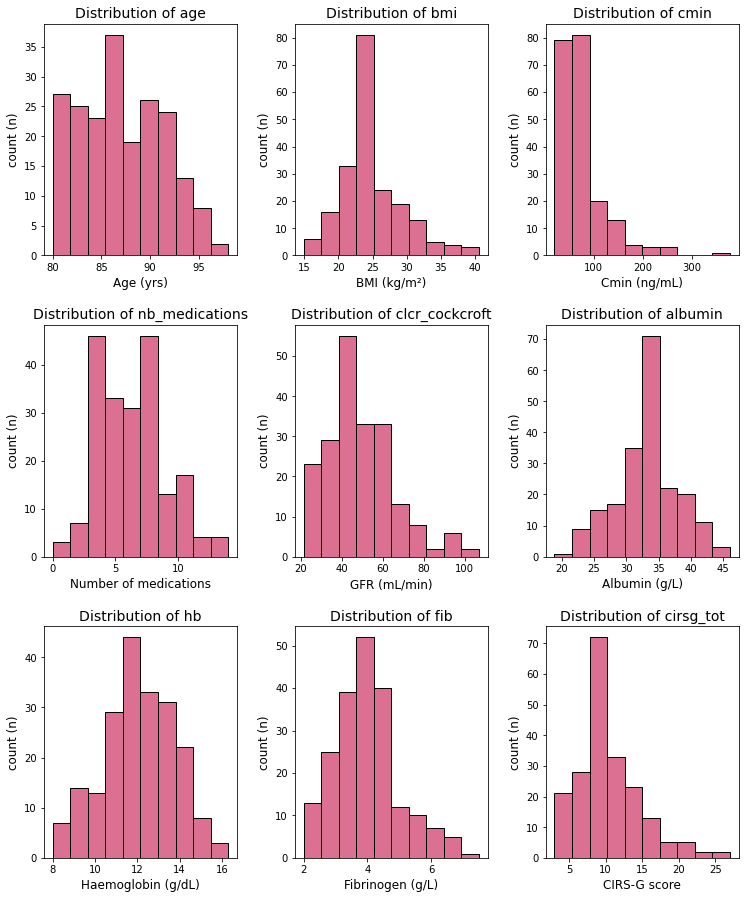

          age     bmi    cmin  nb_medications  clcr_cockcroft  albumin  \
count  204.00  204.00  204.00          204.00          204.00   204.00   
mean    87.05   24.89   70.96            6.20           49.48    33.13   
std      4.32    4.40   50.24            2.66           16.34     4.79   
min     80.00   14.90   20.00            0.00           21.50    18.90   
25%     83.58   22.50   40.60            4.00           38.00    30.75   
50%     86.58   24.20   57.98            6.00           47.00    33.00   
75%     90.57   26.70   85.08            8.00           58.00    36.00   
max     98.01   40.60  378.00           14.00          107.00    46.00   

           hb     fib  cirsg_tot  
count  204.00  204.00     204.00  
mean    12.06    3.99      10.43  
std      1.70    1.01       4.30  
min      8.00    2.00       3.00  
25%     10.90    3.30       8.00  
50%     12.00    3.90      10.00  
75%     13.30    4.51      12.00  
max     16.30    7.50      27.00  


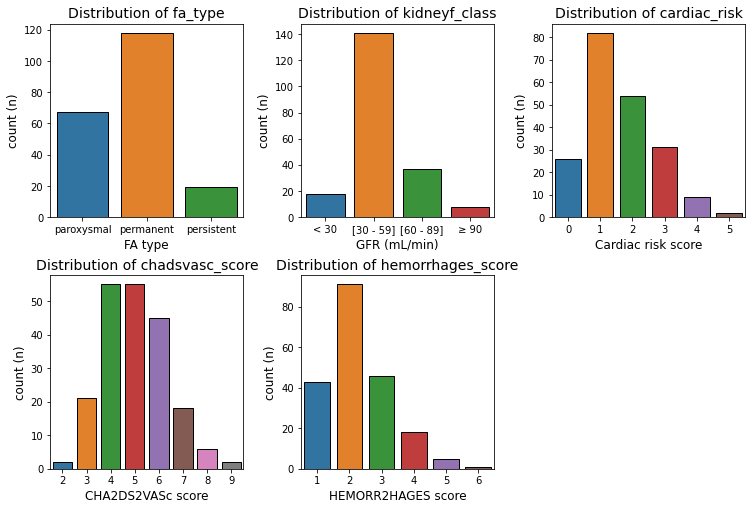

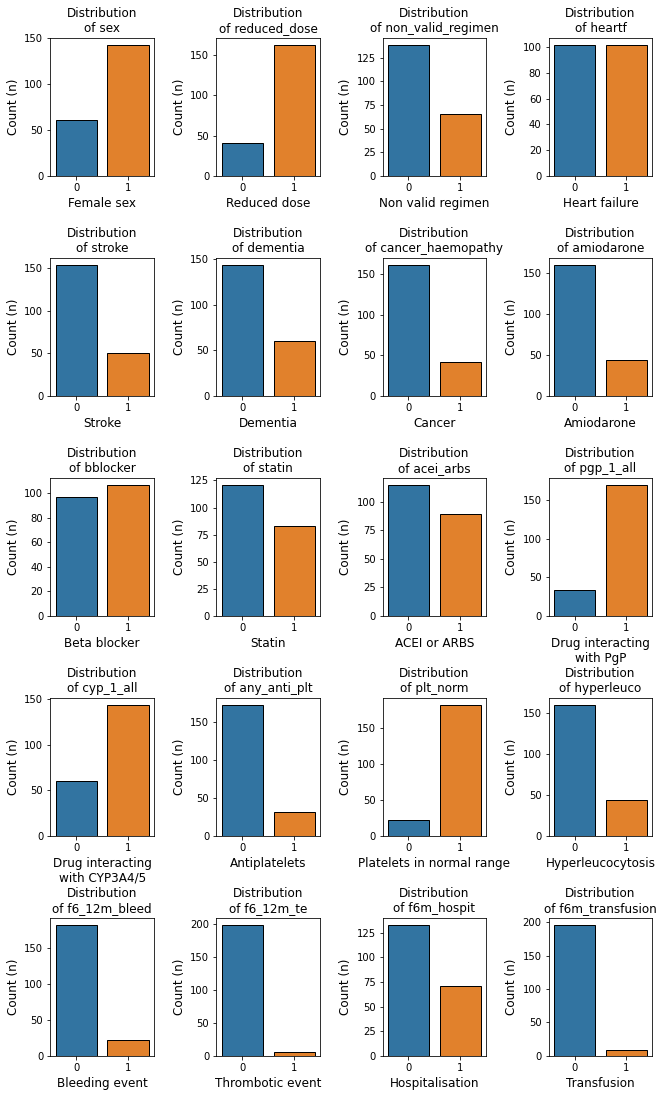

In [10]:
numerical_features = ['age', 'bmi', 'cmin', 'nb_medications', 'clcr_cockcroft',
               'albumin', 'hb', 'fib', 'cirsg_tot']
numerical_labels = ['Age (yrs)', 'BMI (kg/m²)', 'Cmin (ng/mL)', 'Number of medications', 'GFR (mL/min)',
               'Albumin (g/L)', 'Haemoglobin (g/dL)', 'Fibrinogen (g/L)', 'CIRS-G score']

display(HTML(f"""
<h2>Errors and outliers</h2>
<h3>Numerical features</h3>
"""))

fig1, ax1 = plt.subplots(nrows = 3, ncols = 3, figsize=(1.5*8.3, 1.1*11.7))
fig1.subplots_adjust(hspace = 0.3, wspace = 0.3, top = 0.9, bottom = 0.0)

ax1_ax = [(0,0), (0,1), (0,2),
          (1,0), (1,1), (1,2),
          (2,0), (2,1), (2,2)
         ]

for feature, xlabel, ax in zip(numerical_features, numerical_labels, ax1_ax):
    ax1[ax].hist(df2[feature], color = 'palevioletred', edgecolor = 'black')
    ax1[ax].set_title(f'Distribution of {feature}', size = 14)
    ax1[ax].set_ylabel('count (n)', size = 12)
    ax1[ax].set_xlabel(xlabel, size = 12)


plt.savefig('fig1_hist')
plt.show()


display(HTML(f"""
<div class = "all">
    <p>Plotting histograms reveals that, overall, outliers should not be a concern with this dataset, with <code>cmin</code>
    being the only feature with a possible outlier. The mean value of <code>cmin</code> in {np.mean(df2.cmin):.1f} ng/mL and the 
    potential outlier has a value of {np.max(df2.cmin):.1f} ng/mL. Such variability exists in elderly patients, there is therefore
    no reason to suppose this value is an error. However, the legitimity of this value in a machine learning model could be
    debated, as this high concentration could be due to acute conditions and not reflect "general" residual concentrations in
    this population. For the present project, the value will be kept as previous works on this data have emphasised on the 
    important pharmacokinetics inter-individual variability.
    </p>
    <p>
    Several variables on the other hand seemed to be right skewed, such as <code>cmin</code>, <code>cirsg_tot</code>, 
    <code>clcr_cockcroft</code>... No specific treatment should be applied to these variables, as the bias seem overall limited,
    and would not justify a log transformation.
    </p>
    <p>
    Using the <code>describe()</code> function on numerical features confirms that none of them seem to contain error values. 
    </p>
</div>"""))

print(df2[numerical_features].describe().round(2))

display(HTML(f"""
<h3>Categorical features</h3>
"""))

categorical_features = ['fa_type', 'kidneyf_class', 'cardiac_risk', 'chadsvasc_score', 'hemorrhages_score']
categorical_labels = ['FA type', 'GFR (mL/min)', 'Cardiac risk score', 'CHA2DS2VASc score', 'HEMORR2HAGES score']


fig2, ax2 = plt.subplots(nrows = 2, ncols = 3, figsize = (1.5*8.3, 0.7*11.7))

ax2_ax = [
    (0,0), (0,1), (0,2),
    (1,0), (1,1),
]

fig2.subplots_adjust(hspace = 0.3, wspace = 0.3)

for feature, xlabel, ax in zip(categorical_features, categorical_labels, ax2_ax):
    sns.countplot(x = feature, data = df2, edgecolor = 'black', ax = ax2[ax])
    ax2[ax].set_title(f'Distribution of {feature}', size = 14)
    ax2[ax].set_xlabel(xlabel, size = 12)
    ax2[ax].set_ylabel('count (n)', size = 12)
    
ax2[1,2].remove()

plt.savefig('fig2_count')
plt.show()

display(HTML(f"""
<div class ='all'>
    <p>No categorical / ordinal feature seems to contain any visual outlier or visible error. Scores could have been considered
    as numerical variables, however CHA2DS2VASc and HEMORR2HAGES consists of a limited number of items adding +1 or +2 to the
    final score, therefore these scores can only take a limited number of values (compared to CIRS-G for instance).
    </p>
</div>
"""))


display(HTML(f"""
<h3>Binary variables</h3>
"""))

binary_features = ['sex', 'reduced_dose', 'non_valid_regimen', 'heartf', 'stroke', 'dementia', 'cancer_haemopathy', 'amiodarone', 'bblocker', 'statin', 'acei_arbs', 'pgp_1_all', 'cyp_1_all', 'any_anti_plt', 'plt_norm', 'hyperleuco', 'f6_12m_bleed', 'f6_12m_te', 'f6m_hospit', 'f6m_transfusion']
binary_labels = ['Female sex', 'Reduced dose', 'Non valid regimen', 'Heart failure', 'Stroke', 'Dementia', 'Cancer', 'Amiodarone', 'Beta blocker', 'Statin', 'ACEI or ARBS', 'Drug interacting\nwith PgP', 'Drug interacting\nwith CYP3A4/5', 'Antiplatelets', 'Platelets in normal range', 'Hyperleucocytosis', 'Bleeding event', 'Thrombotic event', 'Hospitalisation', 'Transfusion']

fig3, ax3 = plt.subplots(nrows = 5, ncols = 4, figsize = (1.3*8.3, 1.6*11.7))
fig3.subplots_adjust(hspace = 0.6, wspace = 0.6)

ax3_ax = [
    (0,0), (0,1), (0,2), (0,3),
    (1,0), (1,1), (1,2), (1,3),
    (2,0), (2,1), (2,2), (2,3),
    (3,0), (3,1), (3,2), (3,3),
    (4,0), (4,1), (4,2), (4,3)
]

for feature, xlabel, ax in zip(binary_features, binary_labels, ax3_ax):
    sns.countplot(x = feature, data = df2, ax = ax3[ax], edgecolor = 'black')
    ax3[ax].set_title(f'Distribution\nof {feature}', size = 12)
    ax3[ax].set_ylabel('Count (n)', size = 12)
    ax3[ax].set_xlabel(xlabel, size = 12)

plt.savefig('fig3_count')
plt.show()

display(HTML(f"""
<div class = 'all'>
    <p>No binary feature seems to contain errors. Some features displayed substantial unbalancing such as
    <code>f6_12m_te</code> and <code>f6m_transfusion</code>, however it was excepted as it is clinically relevant.
    </p>
</div>
"""))



<h1>Exploratory Data Analysis</h1>

In [11]:
pval_age_gfr = spearmanr(df2.age, df2.clcr_cockcroft)[1]
pval_bmi_gfr = spearmanr(df2.bmi, df2.clcr_cockcroft)[1]
pval_bmi_nbmed = spearmanr(df2.bmi, df2.nb_medications)[1]
pval_cmin_nbmed = spearmanr(df2.cmin, df2.nb_medications)[1]
pval_cirsg_nbmed = spearmanr(df2.cirsg_tot, df2.nb_medications)[1]
pval_albumin_hb = spearmanr(df2.albumin, df2.hb)[1]
pval_albumin_cirsg = spearmanr(df2.albumin, df2.cirsg_tot)[1]
pval_hb_cirsg = spearmanr(df2.hb, df2.cirsg_tot)[1]
pval_albumin_fib = spearmanr(df2.albumin, df2.fib)[1]
pval_cmin_cirsg = spearmanr(df2.cmin, df2.cirsg_tot)[1]

display(HTML(f"""
<div class = 'all'>
<h2>Exploratory Data Analysis</h2>
    <p>As previously stated, data visualisations to gain insight from geriatric patients were already performed in part I of this
project that can be consulted <a href = 'https://nbviewer.org/github/foulongeo/adage_viz/blob/main/p1_adage_viz_prod.ipynb'>here</a>.
    </p>
    <h3>Pairplot</h3>
    <p>A first look on numerical features using <code>sns.pairplot()</code> allow us to draw insights on how numerical features
may correlate with each other. With hue parameter being set as <code>f6_12m_bleed</code>, we can see that the distribution
of numerical features may not significantly differ in patients that bled compared to those who did not. Only <code>clcr_cockcroft</code>
distribution could be slightly different, with a peak at a lower value in patients that bled. However it is important to
note that due to the small number of observations in the bled group, all distributions look pretty flat, making it delicate to 
draw conclusions.
    </p>
    <p>
    No strong correlation between numerical variables was visually found at first sight. Carefull visual analysis however
    led to the following conclusions:</p>
    <ul>
        <li><code>age</code> and <code>clcr_cockcroft</code>: a pattern of GFR decreasing with age was observed as expected
        since age is a parameter of Cockcroft formula. Correlation was confirmed by Spearman's test ({pval_txt(pval_age_gfr)}).
        It is nevertheless interesting to observed a strong correlation in this limited age range ([{int(np.min(df2.age))} - {int(np.max(df2.age))}] years).</li>
        <li><code>bmi</code> and <code>clcr_cockcroft</code>: patients with higher BMI also had a higher GFR (Spearman: 
        {pval_txt(pval_bmi_gfr)}). This was expected as both BMI and Cockcroft formulae integrate body weight as parameter.</li>
        <li><code>bmi</code> and <code>nb_medications</code>: patients with higher BMI took a higher number of medications
        (Spearman: {pval_txt(pval_bmi_nbmed)}). We could hypothesise that patients with higher BMI are more likely to 
        be treated by statins or hypolipidemic drug. Higher BMI may also indirectly reflect a higher cardiac risk and imply
        many additional drugs such as beta blockers, antihypertensive drug, antiplatelet etc.</li>
        <li><code>cirsg_tot</code> and <code>nb_medications</code>: patients with higher CIRS-G score tend to take a higher
        number of medications (Spearman: {pval_txt(pval_cirsg_nbmed)}). CIRS-G score reflects the degree of polypathology, 
        it this therefore expected that polypathology correlates with polymedication.</li>
        <li><code>albumin</code>, <code>hb</code> and <code>cirsg_tot</code>: the levels of albumin and haemoglobin were
        positively correlated (Spearman: {pval_txt(pval_albumin_hb)}); as proteins it was expected that they would vary in
        the same manner. Lower levels of either albumin or haemoglobin were found in patients with higher CIRS-G score
        (Spearman: {pval_txt(pval_albumin_cirsg)} for albumin and {pval_txt(pval_hb_cirsg)} for haemoglobin). Several conditions
        could lead to lower levels of albumin and haemoglobin such as inflammatory state, the later more likely to be found
        polypathological patients.</li>
        <li><code>albumin</code> and <code>fib</code>: albumin and fibrinogen levels are inversely proportional 
        (Spearman: {pval_txt(pval_albumin_fib)}); which may also indirectly reflect the presence of an inflammatory state
        in elderly patients as fibrinogen usually increases with inflammation. Fibrinogen however was not correlated with
        the CIRS-G score.</li>
        <li><code>cmin</code> and <code>nb_medications</code>: patients taking a higher number of medications tend to have
        higher residual doac concentrations (Spearman: {pval_txt(pval_cmin_nbmed)}). While this could make sense considering
        that the more medications a patient takes, the higher the probability of taking drugs that interacts with either PgP
        or CYP3A4/5, therefore competing for elimination. However this assumption should be checked independently among patients
        taking apixaban and rivaroxaban (For this project, concentrations were left in ng/mL whereas best practice would have
        been to convert them into nM for comparison purpose).</li>
        <li><code>cmin</code> and <code>cirsg_tot</code>: the fact that patients with higher CIRS-G score have higher residual
        concentration (Spearman: {pval_txt(pval_cmin_cirsg)}) could be linked to the correlation between <code>cirsg_tot</code>
        and <code>nb_medications</code> previously described, while polypathology could also have its own influence (<i>i.e.</i>
        chronic kidney disease). Nevertheless these correlations should be interpreted with caution: inter-individual variability
        of PK response to rivaroxaban and apixaban isn't properly established yet, especially in elderly patients, and the presence
        of an outlier in <code>cmin</code> may lead to inacurate results.</li>        
    </ul>

</div>
"""))

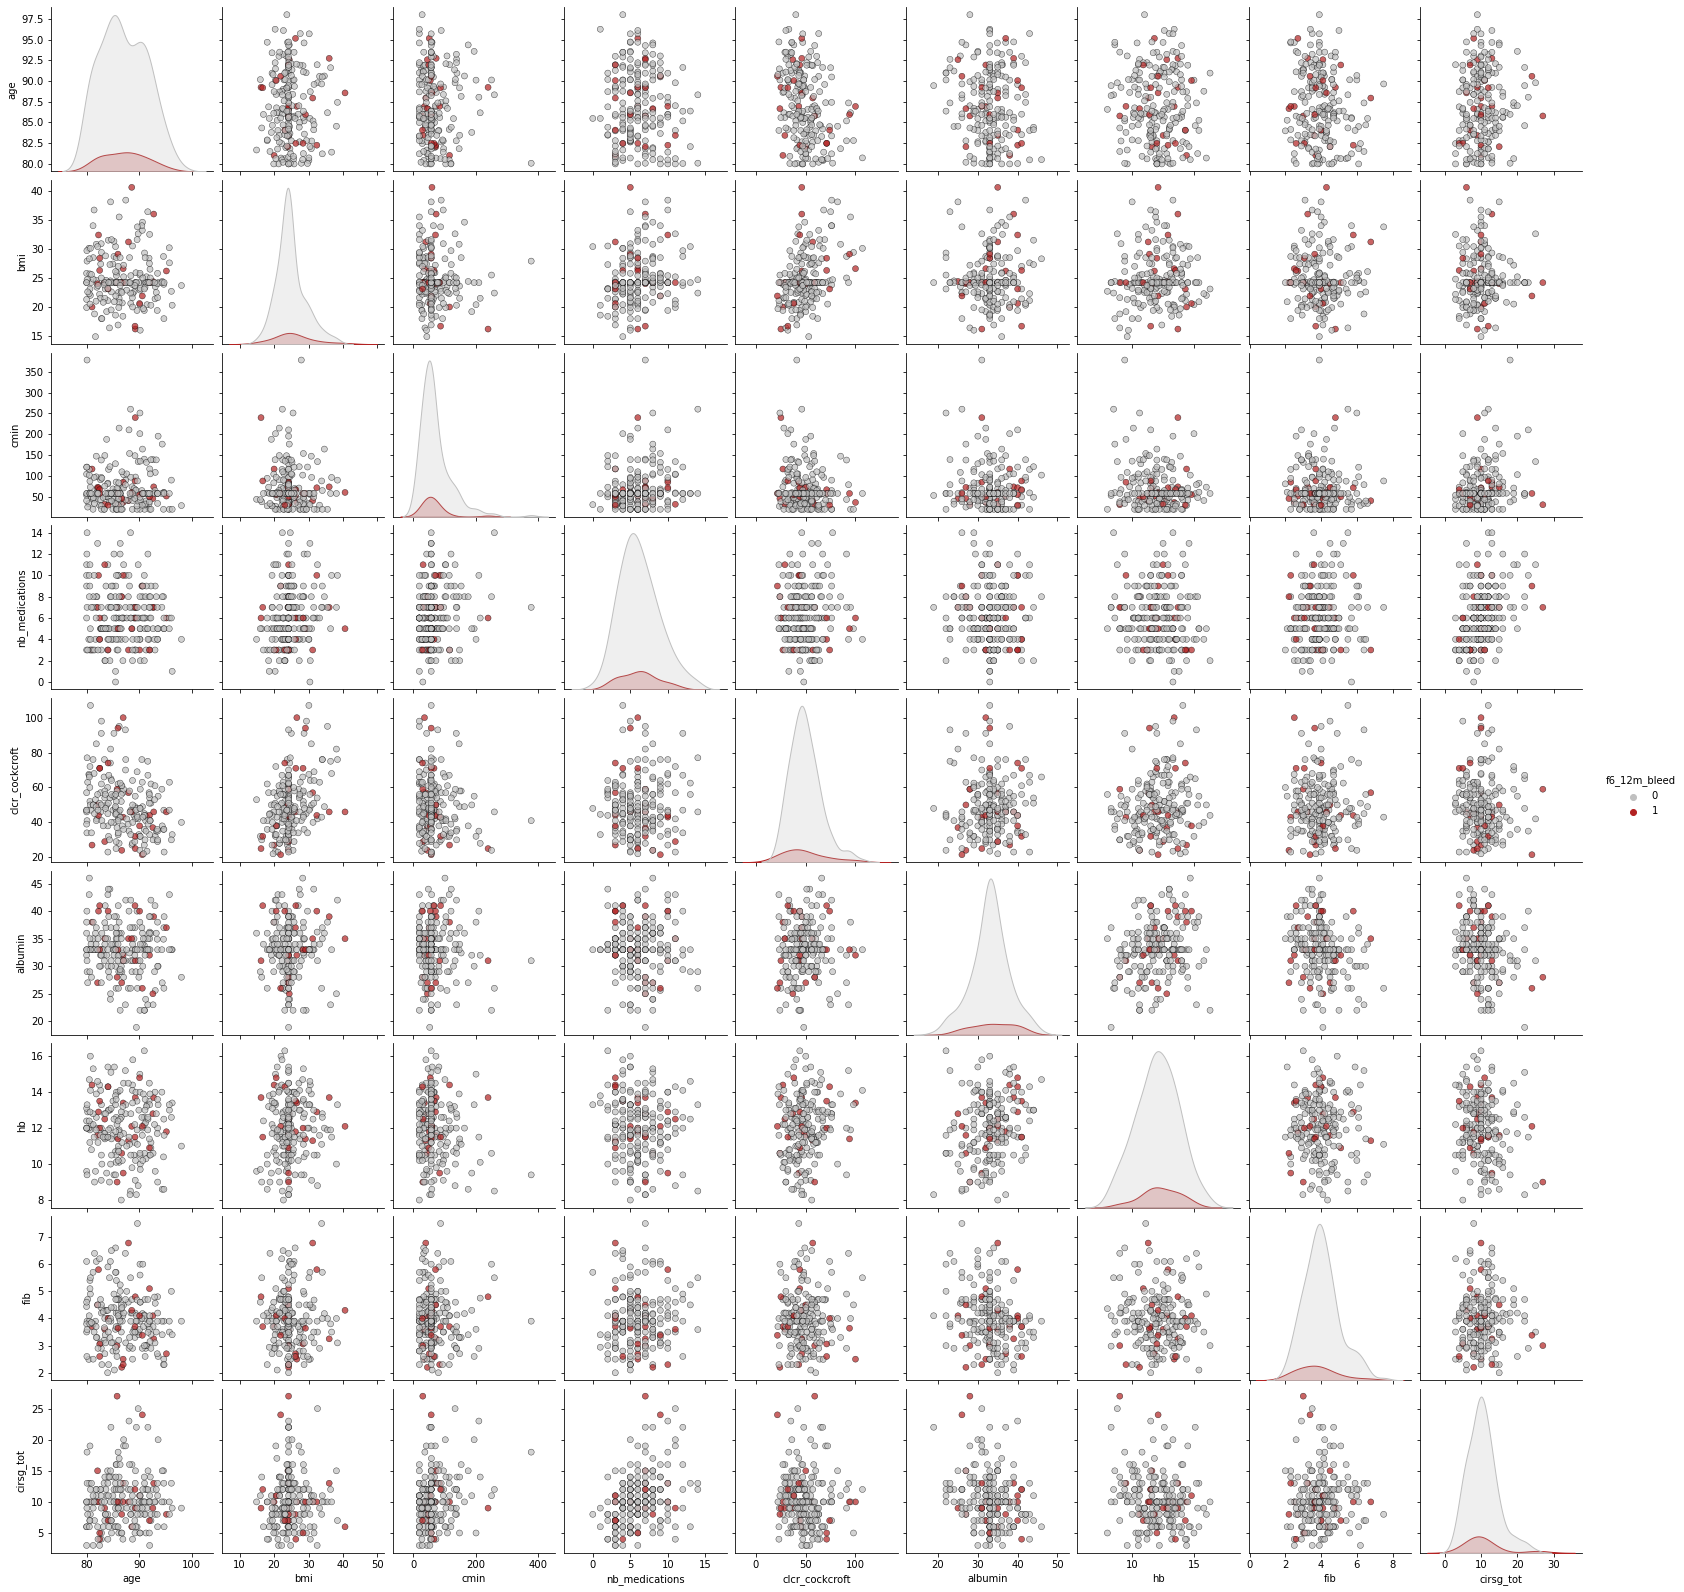

In [12]:
numerical_features = ['age', 'bmi', 'cmin', 'nb_medications', 'clcr_cockcroft',
               'albumin', 'hb', 'fib', 'cirsg_tot']

numerical_features_pp = numerical_features+['f6_12m_bleed']
sns.pairplot(data = df2[numerical_features_pp], hue = 'f6_12m_bleed', palette = {0 : 'silver', 1 : 'firebrick'}, plot_kws={'alpha': 0.7, 'edgecolor' : 'black'})
plt.show()

In [13]:
#Exploring significant correlations
for feat1 in numerical_features:
    display(HTML(f'<b>{feat1.upper()}</b>'))
    for feat2 in numerical_features:
        if feat2 == feat1:
            pass
        else: 
            pval = spearmanr(df2[feat1], df2[feat2])[1]
            if pval < 0.05:
                display(HTML(f"""
                p-value for {feat1} and {feat2} : {pval_txt(pval)}
                """))
    print('......................................')


......................................


......................................


......................................


......................................


......................................


......................................


......................................


......................................


......................................


<h1>Bibliography</h1>

<div class ='all'>
[1]	C. B. Granger et al., ‘Apixaban versus warfarin in patients with atrial fibrillation’, N. Engl. J. Med., vol. 365, no. 11, pp. 981–992, Sep. 2011, doi: 10.1056/NEJMoa1107039.
<br>[2]	M. R. Patel et al., ‘Rivaroxaban versus warfarin in nonvalvular atrial fibrillation’, N. Engl. J. Med., vol. 365, no. 10, pp. 883–891, Sep. 2011, doi: 10.1056/NEJMoa1009638.
<br>[3]	S. J. Connolly et al., ‘Dabigatran versus warfarin in patients with atrial fibrillation’, N. Engl. J. Med., vol. 361, no. 12, pp. 1139–1151, Sep. 2009, doi: 10.1056/NEJMoa0905561.
<br>[4]	T. Ikeda et al., ‘Real-world outcomes of the Xarelto Post-Authorization Safety & Effectiveness Study in Japanese Patients with Atrial Fibrillation (XAPASS)’, J Cardiol, vol. 74, no. 1, pp. 60–66, Jul. 2019, doi: 10.1016/j.jjcc.2019.01.001.
<br>[5]	S. Windecker et al., ‘Antithrombotic Therapy in Patients With Atrial Fibrillation and Acute Coronary Syndrome Treated Medically or With Percutaneous Coronary Intervention or Undergoing Elective Percutaneous Coronary Intervention: Insights From the AUGUSTUS Trial’, Circulation, vol. 140, no. 23, pp. 1921–1932, 03 2019, doi: 10.1161/CIRCULATIONAHA.119.043308.
<br>[6]	GWT-TUD GmbH, ‘Prospective Register Study to Record Safety and Efficacy of New Oral Anticoagulants’, clinicaltrials.gov, Clinical trial registration NCT01588119, Nov. 2018. Accessed: Jan. 05, 2021. [Online]. Available: https://clinicaltrials.gov/ct2/show/NCT01588119
<br>[7]	Thrombosis Research Institute, ‘Prospective, Multi Centre, International Registry of Male and Female Patients Newly Diagnosed With Atrial Fibrillation.’, clinicaltrials.gov, Clinical trial registration NCT01090362, Dec. 2014. Accessed: Jan. 04, 2021. [Online]. Available: https://clinicaltrials.gov/ct2/show/NCT01090362
<br>[8]	Japan Cardiovascular Research Foundation, ‘Registry Study on the Effectiveness of Rivaroxaban in Patients With Non-valvular Atrial Fibrillation Managed by General Practitioners(GENERAL Study)’, clinicaltrials.gov, Clinical trial registration NCT02633982, Dec. 2015. Accessed: Jan. 05, 2021. [Online]. Available: https://clinicaltrials.gov/ct2/show/NCT02633982
<br>[9]	G. Y. H. Lip et al., ‘Left atrial thrombus resolution in atrial fibrillation or flutter: Results of a prospective study with rivaroxaban (X-TRA) and a retrospective observational registry providing baseline data (CLOT-AF)’, Am Heart J, vol. 178, pp. 126–134, Aug. 2016, doi: 10.1016/j.ahj.2016.05.007.
<br>[10]	P. Kirchhof et al., ‘Global Prospective Safety Analysis of Rivaroxaban’, J Am Coll Cardiol, vol. 72, no. 2, pp. 141–153, 10 2018, doi: 10.1016/j.jacc.2018.04.058.
<br>[11]	H. Shimokawa et al., ‘The EXPAND study: Efficacy and safety of rivaroxaban in Japanese patients with non-valvular atrial fibrillation’, Int J Cardiol, vol. 258, pp. 126–132, 01 2018, doi: 10.1016/j.ijcard.2018.01.141.
<br>[12]	M. Yasaka, M. Umeyama, H. Kataoka, and H. Inoue, ‘Secondary stroke prevention with apixaban in nonvalvular atrial fibrillation: A subgroup analysis of the STANDARD study’, J Stroke Cerebrovasc Dis, vol. 29, no. 9, p. 105034, Sep. 2020, doi: 10.1016/j.jstrokecerebrovasdis.2020.105034.
<br>[13]	E. Pautas et al., ‘Genetic factors (VKORC1, CYP2C9, EPHX1, and CYP4F2) are predictor variables for warfarin response in very elderly, frail inpatients’, Clin Pharmacol Ther, vol. 87, no. 1, pp. 57–64, Jan. 2010, doi: 10.1038/clpt.2009.178.
<br>[14]	O. Hanon et al., ‘Bleeding risk with rivaroxaban compared with vitamin K antagonists in patients aged 80 years or older with atrial fibrillation’, Heart, vol. 2020, no. 0, pp. 1–7, Dec. 2020, doi: 10.1136/heartjnl-2020-317923.
<br>[15]	M. Sharma, V. R. Cornelius, J. P. Patel, J. G. Davies, and M. Molokhia, ‘Efficacy and Harms of Direct Oral Anticoagulants in the Elderly for Stroke Prevention in Atrial Fibrillation and Secondary Prevention of Venous Thromboembolism: Systematic Review and Meta-Analysis’, Circulation, vol. 132, no. 3, pp. 194–204, Jul. 2015, doi: 10.1161/CIRCULATIONAHA.114.013267.

</div>